In [1]:
import os
import cv2
import numpy
import pandas
import pickle
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
from torchvision import datasets
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [2]:
### Constants
TRAIN_PATH = "./dataset_no0_w_new_data_normalize_distribution_917/train_data" # path to the dataset
TEST_PATH = "./dataset_no0_w_new_data_normalize_distribution_917/test_data" # path to the dataset
VAL_PATH = "./dataset_no0_w_new_data_normalize_distribution_917/val_data" # path to the dataset
LABEL_PATH = './media/labels_no0.csv' # path to the labels csv file
# RESULT_PATH = "dataloader" + "_" + "max" + "_" + "3x5-3x3" + "_" + "old_dataset_defmodel" # path to the labels csv file
RESULT_PATH = "bestone_" + "dataset_no0_w_new_data_normalize_distribution_917" # path to the labels csv file
BATCH_SIZE_VAL = 64 # size of batches during training
STEPS_X_EPOCH = 2000 # number of steps per epoch
N_EPOCHS = 100 # number of epochs for training
IMG_DIM = (32,32,3) # dimensions of the images (height, width, channels)

In [3]:
### Functions
def sorted_imagefolder(root, transform):
	# Ensure the folder names are sorted numerically, if find file ".DS_Store" remove it
	if ".DS_Store" in os.listdir(root):
		os.remove(os.path.join(root, ".DS_Store"))
	
	# Sort the folder names numerically
	folder_names = sorted(os.listdir(root), key=lambda x: int(x))

	# Create a mapping of folder names to numeric labels
	class_to_idx = {folder: idx for idx, folder in enumerate(folder_names)}

	# Create an ImageFolder instance
	dataset = datasets.ImageFolder(root=root, transform=transform)

	# Override the class_to_idx to match the sorted order
	dataset.class_to_idx = class_to_idx

	# Update the dataset to ensure it uses our sorted classes
	dataset.classes = folder_names  # Update classes attribute
	dataset.samples = [(os.path.join(root, folder, f), class_to_idx[folder]) 
					for folder in folder_names 
					for f in os.listdir(os.path.join(root, folder))]

	return dataset

def grayscale(img):
	import torchvision.transforms as transforms
	from torchvision.transforms import functional
	"""function to convert the image to grayscale"""
	if img is None or not isinstance(img, numpy.ndarray) or len(img.shape) == 2:  # Assuming 'grayscale' starts here
		return img  # return it as is
	else:
		img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # convert to grayscale
		return img

def equalize(img):
	"""Function to equalize the histogram for contrast adjustment."""
	if img is None:
		return img  # Return None as is

	# Check if img is a tensor and convert to NumPy array
	if isinstance(img, torch.Tensor):
		img = img.detach().cpu().numpy()  # Convert to NumPy array

	if not isinstance(img, numpy.ndarray):
		print("Received non-array image: ", type(img))
		return img

	img = img.astype(numpy.uint8)  # Ensure the image is 8-bit grayscale
	img = cv2.equalizeHist(img)  # Apply histogram equalization

	return img

In [ ]:
def tsd_model(n_classes):
	"""Defines the CNN model."""
	n_classes = n_classes
	n_kernels = 60
	n_nodes = 500
	kernel_size_5x5 = (5, 5)
	kernel_size_3x3 = (3, 3)
	pool_size = (2, 2)
	dropout_rate = 0.5
	learning_rate = 0.001
	model = Sequential()

	# First convolutional block
	model.add(Conv2D(n_kernels, kernel_size_5x5, input_shape=(IMG_DIM[0], IMG_DIM[1], 1), activation='relu'))
	model.add(Conv2D(n_kernels, kernel_size_5x5, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_5x5, activation='relu'))  # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size))  # max pooling layer

	# Second convolutional block
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(Conv2D(n_kernels, kernel_size_3x3, activation='relu'))  # 2nd conv layer
	model.add(MaxPooling2D(pool_size=pool_size))  # max pooling layer
	model.add(Dropout(dropout_rate))  # dropout layer

	# Fully connected layers
	model.add(Flatten())  # flatten the output for the fully connected layer
	model.add(Dense(n_nodes, activation='relu'))  # fully connected layer
	model.add(Dropout(dropout_rate))  # dropout layer
	model.add(Dense(n_classes, activation='softmax'))  # output layer

	# Compile the model
	model.compile(optimizer=Adam(learning_rate=learning_rate), 
				loss='categorical_crossentropy', 
				metrics=['accuracy'])
	return model

In [5]:
### Classes
class CustomTransform:
	"""Custom transformation class to apply grayscale, histogram equalization, and normalization."""
	def __init__(self):
		pass

	def __call__(self, img):
		# Apply the custom transformations
		img = grayscale(img) # convert to grayscale
		img = equalize(img) # equalize histogram
		img = img / 255 # normalize pixel values to the range [0, 1] instead of [0, 255]
		return img

# class TrafficSignModel:
# 	def __init__(self, n_classes, img_dim, n_kernels=60, n_nodes=500, kernel_size_5x5=(5, 5), 
# 				 kernel_size_3x3=(3, 3), pool_size=(2, 2), dropout_rate=0.5, learning_rate=0.001):
# 		"""
# 		Initializes the TSignModel class with the specified parameters.
		
# 		Parameters:
# 		- n_classes (int): Number of output classes.
# 		- img_dim (tuple): Dimensions of the input images (height, width, channels).
# 		- n_kernels (int): Number of kernels for convolutional layers.
# 		- n_nodes (int): Number of nodes in the fully connected layer.
# 		- kernel_size_5x5 (tuple): Size of the first convolutional kernel.
# 		- kernel_size_3x3 (tuple): Size of the second convolutional kernel.
# 		- pool_size (tuple): Size of the pooling window.
# 		- dropout_rate (float): Rate of dropout for regularization.
# 		- learning_rate (float): Learning rate for the optimizer.
# 		"""
# 		self.n_classes = n_classes
# 		self.img_dim = img_dim
# 		self.n_kernels = n_kernels
# 		self.n_nodes = n_nodes
# 		self.kernel_size_5x5 = kernel_size_5x5
# 		self.kernel_size_3x3 = kernel_size_3x3
# 		self.pool_size = pool_size
# 		self.dropout_rate = dropout_rate
# 		self.learning_rate = learning_rate
# 		self.model = self._build_model()

# 	def _build_model(self):
# 		"""Defines the CNN model."""
# 		model = Sequential()

# 		# # First convolutional block
# 		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, input_shape=(self.img_dim[0], self.img_dim[1], 1), activation='relu'))
# 		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
# 		# model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
# 		# model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer

# 		# # Second convolutional block
# 		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 3rd conv layer
# 		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 4th conv layer
# 		# model.add(Conv2D(self.n_kernels // 2, self.kernel_size_3x3, activation='relu'))  # 4th conv layer
# 		# model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer
# 		# model.add(Dropout(self.dropout_rate))  # dropout layer

# 		# # Fully connected layers
# 		# model.add(Flatten())  # flatten the output for the fully connected layer
# 		# model.add(Dense(self.n_nodes, activation='relu'))  # fully connected layer
# 		# model.add(Dropout(self.dropout_rate))  # dropout layer
# 		# model.add(Dense(self.n_classes, activation='softmax'))  # output layer

# 		# First convolutional block
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, input_shape=(self.img_dim[0], self.img_dim[1], 1), activation='relu'))
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_5x5, activation='relu'))  # 2nd conv layer
# 		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer

# 		# Second convolutional block
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
# 		model.add(Conv2D(self.n_kernels, self.kernel_size_3x3, activation='relu'))  # 2nd conv layer
# 		model.add(MaxPooling2D(pool_size=self.pool_size))  # max pooling layer
# 		model.add(Dropout(self.dropout_rate))  # dropout layer

# 		# Fully connected layers
# 		model.add(Flatten())  # flatten the output for the fully connected layer
# 		model.add(Dense(self.n_nodes, activation='relu'))  # fully connected layer
# 		model.add(Dropout(self.dropout_rate))  # dropout layer
# 		model.add(Dense(self.n_classes, activation='softmax'))  # output layer

# 		# Compile the model
# 		model.compile(optimizer=Adam(learning_rate=self.learning_rate), 
# 					loss='categorical_crossentropy', 
# 					metrics=['accuracy'])
# 		return model

# 	def get_model(self):
# 		"""Returns the constructed model."""
# 		return self.model

In [6]:
transform = CustomTransform()

# Split dataset into train, val, and test sets
train_dataset = sorted_imagefolder(TRAIN_PATH, transform)
test_dataset = sorted_imagefolder(TEST_PATH, transform)
val_dataset = sorted_imagefolder(VAL_PATH, transform)

# total number of classes
n_classes = len(train_dataset.classes)
print("Total Classes Detected:", n_classes)

Total Classes Detected: 37


In [7]:
# Create DataLoader for batching
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE_VAL, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE_VAL, shuffle=False)

# print the shapes of the datasets
print("Data Shapes")
print("Train", len(train_loader.dataset)) # print training data shape
print("Validation", len(val_loader.dataset)) # print validation data shape
print("Test", len(test_loader.dataset)) # print test data shape

Data Shapes
Train 22963
Validation 2849
Test 2849


data shape  (37, 2) <class 'pandas.core.frame.DataFrame'>
{0: {'id': 0, 'n': 712}, 1: {'id': 1, 'n': 720}, 2: {'id': 2, 'n': 718}, 3: {'id': 3, 'n': 729}, 4: {'id': 4, 'n': 728}, 5: {'id': 5, 'n': 717}, 6: {'id': 6, 'n': 707}, 7: {'id': 7, 'n': 726}, 8: {'id': 8, 'n': 724}, 9: {'id': 9, 'n': 724}, 10: {'id': 10, 'n': 737}, 11: {'id': 11, 'n': 654}, 12: {'id': 12, 'n': 537}, 13: {'id': 13, 'n': 591}, 14: {'id': 14, 'n': 721}, 15: {'id': 15, 'n': 724}, 16: {'id': 16, 'n': 305}, 17: {'id': 17, 'n': 484}, 18: {'id': 18, 'n': 722}, 19: {'id': 19, 'n': 527}, 20: {'id': 20, 'n': 695}, 21: {'id': 21, 'n': 412}, 22: {'id': 22, 'n': 724}, 23: {'id': 23, 'n': 606}, 24: {'id': 24, 'n': 735}, 25: {'id': 25, 'n': 706}, 26: {'id': 26, 'n': 312}, 27: {'id': 27, 'n': 712}, 28: {'id': 28, 'n': 321}, 29: {'id': 29, 'n': 705}, 30: {'id': 30, 'n': 577}, 31: {'id': 31, 'n': 728}, 32: {'id': 32, 'n': 537}, 33: {'id': 33, 'n': 278}, 34: {'id': 34, 'n': 706}, 35: {'id': 35, 'n': 408}, 36: {'id': 36, 'n': 594}}

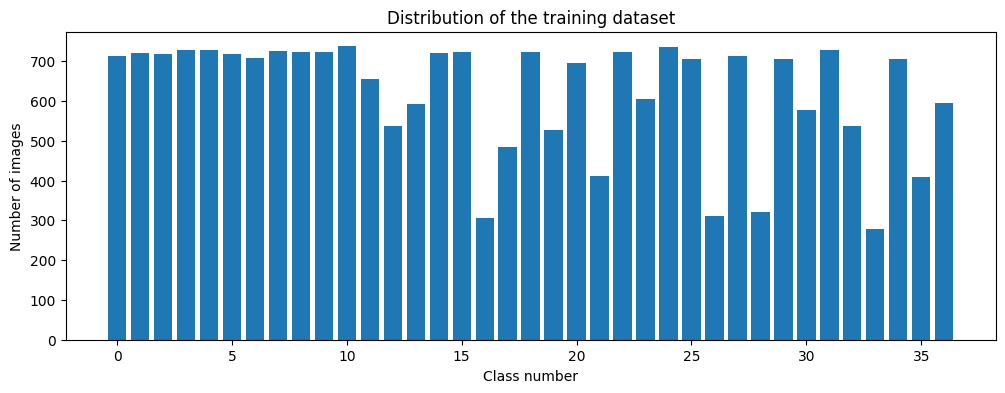

In [8]:
# read the label data from csv file
labels = pandas.read_csv(LABEL_PATH) # read the labels csv file
print("data shape ", labels.shape, type(labels))

# display some sample images from each class
sample_x_class =  {} # list for the number of samples per class

# Loop through each directory in the provided path
for class_dir in range(n_classes):
    # Full path to the subdirectory
    full_path = os.path.join(TRAIN_PATH, str(class_dir))
    num_dir = {}

    # Only proceed if it's a directory
    if os.path.isdir(full_path):
        num_dir['id'] = class_dir
        num_dir['n'] = len(os.listdir(full_path))
        sample_x_class[class_dir] = num_dir

# print the number of samples per class with the class name
print(f"{sample_x_class}")

sample_x_class_values = [item['n'] for item in sample_x_class.values()]

# plot the distribution of training dataset
plt.figure(figsize=(12, 4))
plt.bar(range(0, n_classes), sample_x_class_values) # create a bar chart for sample distribution
plt.title("Distribution of the training dataset")
plt.xlabel("Class number")
plt.ylabel("Number of images")
plt.show()

In [9]:
X_train = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in train_dataset.imgs])
X_val = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in val_dataset.imgs])
X_test = numpy.array([img_to_array(load_img(img, target_size=IMG_DIM, color_mode='grayscale')) for img, label in test_dataset.imgs])

y_train = numpy.array([label for img, label in train_dataset.imgs])
y_val = numpy.array([label for img, label in val_dataset.imgs])
y_test = numpy.array([label for img, label in test_dataset.imgs])

# reshape the data to add a depth of 1 (grayscale images have only one channel)
X_train = X_train.reshape(X_train.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_val = X_val.reshape(X_val.shape[0], IMG_DIM[0], IMG_DIM[1], 1)
X_test = X_test.reshape(X_test.shape[0], IMG_DIM[0], IMG_DIM[1], 1)

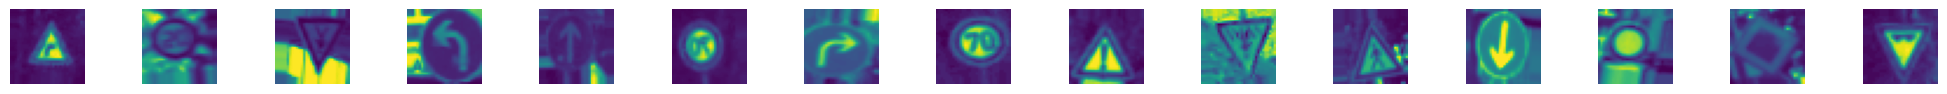

In [10]:
# create an image data generator for augmenting the training data
img_gen = ImageDataGenerator(width_shift_range=0.1, # randomly shift images horizontally by 10%
							height_shift_range=0.1, # randomly shift images vertically by 10%
							zoom_range=0.2, # randomly zoom in or out
							shear_range=0.1, # randomly shear the images
							rotation_range=10, # randomly rotate images by up to 10 degrees
							horizontal_flip=True,
							vertical_flip=True,
							brightness_range=(0.5, 1.5))
img_gen.fit(X_train) # fit the generator on the training data
batches = img_gen.flow(X_train, y_train, batch_size=20) # generate augmented images
X_batch, y_batch = next(batches) # get the next batch

# display some augmented images
fig, axs = plt.subplots(1, 15, figsize=(20, 5))
fig.tight_layout()
for i in range(15):
	axs[i].imshow(X_batch[i].reshape(IMG_DIM[0], IMG_DIM[1])) # reshape to 32x32 and display
	axs[i].axis('off') # hide axis (for cleaner display)
plt.show()

# convert labels to one-hot encoded format
y_train = to_categorical(y_train, n_classes)
y_val = to_categorical(y_val, n_classes)
y_test = to_categorical(y_test, n_classes)

In [11]:
# Save the best model based on validation accuracy
checkpoint = ModelCheckpoint(
	filepath=RESULT_PATH+".keras", # File path to save the best model
	monitor="val_accuracy", # Metric to monitor
	mode="max", # 'max' since we want the highest validation accuracy
	save_best_only=True, # Save only when validation accuracy improves
	verbose=1 # Print a message when saving the model
)

# Stop training when validation accuracy has stopped improving for 'patience' epochs
early_stopping = EarlyStopping(
	monitor="val_accuracy", # Metric to monitor
	mode="max", # Stop when this metric stops improving
	patience=10, # Number of epochs with no improvement after which training will stop
	restore_best_weights=True, # Restore the weights of the best model at the end of training
	verbose=1 # Print a message when stopping
)

# build and train the model
model = tsd_model(n_classes)
print(model.summary())

# train the model
history = model.fit(
	img_gen.flow(X_train, y_train, batch_size=BATCH_SIZE_VAL), # train the model using data augmentation
	steps_per_epoch=STEPS_X_EPOCH, # number of steps per epoch
	epochs=N_EPOCHS, # number of epochs
	validation_data=(X_val, y_val), # validation data
	shuffle=True, # shuffle data during training
	callbacks=[early_stopping, checkpoint] # use the early stopping callback
)

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 28, 28, 60)     │         1,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 20, 60)     │        90,060 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 60)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 8, 8, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 6, 6, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 4, 4, 60)       │        32,460 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 2, 2, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 2, 2, 60)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 240)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 500)            │       120,500 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 500)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 37)             │        18,537 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 418,097 (1.59 MB)

 Trainable params: 418,097 (1.59 MB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/100


/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:24 198ms/step - accuracy: 0.0429 - loss: 3.7281

2024-11-21 16:35:28.971260: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/opt/homebrew/Cellar/python@3.12/3.12.7/Frameworks/Python.framework/Versions/3.12/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)



Epoch 1: val_accuracy improved from -inf to 0.28677, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 75s 37ms/step - accuracy: 0.0661 - loss: 3.5319 - val_accuracy: 0.2868 - val_loss: 2.8210
Epoch 2/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:46 211ms/step - accuracy: 0.1984 - loss: 2.8766

2024-11-21 16:36:47.620033: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 2: val_accuracy improved from 0.28677 to 0.56476, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - accuracy: 0.2393 - loss: 2.6703 - val_accuracy: 0.5648 - val_loss: 1.6078
Epoch 3/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:49 213ms/step - accuracy: 0.3839 - loss: 1.9535
Epoch 3: val_accuracy improved from 0.56476 to 0.65707, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.4120 - loss: 1.8431 - val_accuracy: 0.6571 - val_loss: 1.0499
Epoch 4/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:52 215ms/step - accuracy: 0.5152 - loss: 1.4640

2024-11-21 16:39:26.617220: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 4: val_accuracy improved from 0.65707 to 0.72622, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.5321 - loss: 1.4073 - val_accuracy: 0.7262 - val_loss: 0.7873
Epoch 5/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:54 216ms/step - accuracy: 0.5888 - loss: 1.2242
Epoch 5: val_accuracy improved from 0.72622 to 0.80098, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.6016 - loss: 1.1859 - val_accuracy: 0.8010 - val_loss: 0.5722
Epoch 6/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:58 218ms/step - accuracy: 0.6547 - loss: 1.0331
Epoch 6: val_accuracy improved from 0.80098 to 0.80344, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 40ms/step - accuracy: 0.6592 - loss: 1.0206 - val_accuracy: 0.8034 - val_loss: 0.5492
Epoch 7/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━

2024-11-21 16:44:51.601615: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 8: val_accuracy did not improve from 0.88698
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.7311 - loss: 0.8074 - val_accuracy: 0.8592 - val_loss: 0.4406
Epoch 9/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:59 219ms/step - accuracy: 0.7485 - loss: 0.7624
Epoch 9: val_accuracy did not improve from 0.88698
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 81s 41ms/step - accuracy: 0.7567 - loss: 0.7396 - val_accuracy: 0.8698 - val_loss: 0.3403
Epoch 10/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 6:00 220ms/step - accuracy: 0.7711 - loss: 0.6821
Epoch 10: val_accuracy improved from 0.88698 to 0.91751, saving model to bestone_dataset_no0_w_new_data_normalize_distribution_917.keras
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 82s 41ms/step - accuracy: 0.7725 - loss: 0.6839 - val_accuracy: 0.9175 - val_loss: 0.2529
Epoch 11/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:52 215ms/step - accuracy: 0.7846 - loss: 0.6433
Epoch 11: val_accuracy did not improve from 0.91751
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.7884 

2024-11-21 16:55:31.595994: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 16: val_accuracy did not improve from 0.92453
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.8272 - loss: 0.5027 - val_accuracy: 0.9119 - val_loss: 0.2940
Epoch 17/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:47 212ms/step - accuracy: 0.8221 - loss: 0.5278
Epoch 17: val_accuracy did not improve from 0.92453
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 79s 39ms/step - accuracy: 0.8259 - loss: 0.5225 - val_accuracy: 0.9052 - val_loss: 0.2772
Epoch 18/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:46 211ms/step - accuracy: 0.8307 - loss: 0.5009
Epoch 18: val_accuracy did not improve from 0.92453
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - accuracy: 0.8319 - loss: 0.4990 - val_accuracy: 0.9238 - val_loss: 0.2148
Epoch 19/100
 359/2000 ━━━━━━━━━━━━━━━━━━━━ 5:44 210ms/step - accuracy: 0.8375 - loss: 0.4866
Epoch 19: val_accuracy did not improve from 0.92453
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 78s 39ms/step - accuracy: 0.8369 - loss: 0.4856 - val_accuracy: 0.9186 - val_loss: 0.2560
Epoch 20/100
 359/2000 ━━

2024-11-21 17:16:36.506561: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]



Epoch 32: val_accuracy did not improve from 0.92804
2000/2000 ━━━━━━━━━━━━━━━━━━━━ 80s 40ms/step - accuracy: 0.8635 - loss: 0.4018 - val_accuracy: 0.9161 - val_loss: 0.2646
Epoch 32: early stopping
Restoring model weights from the end of the best epoch: 22.


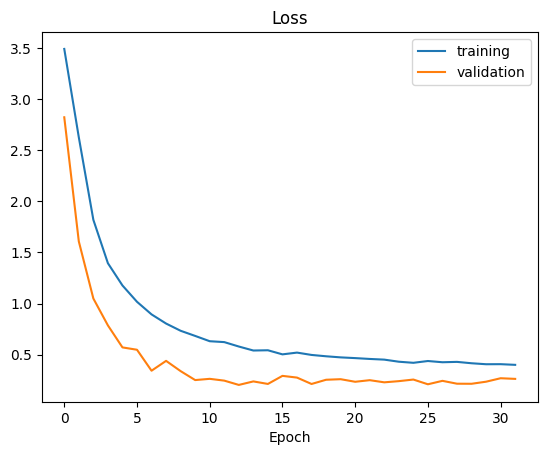

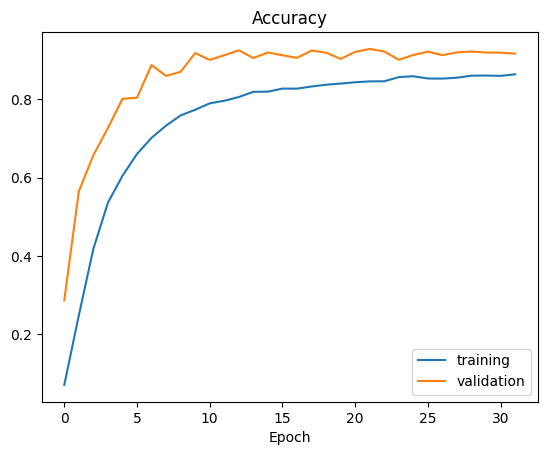

/Users/matt/Documents/GitHub/traffic-signs-classification/.env/lib/python3.12/site-packages/keras/src/saving/saving_lib.py:719: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 34 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Last Validation Loss from Saved Model: 0.25185710191726685
Last Validation Accuracy from Saved Model: 0.9280449151992798


In [12]:
# plot the training and validation loss
plt.figure(1)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['training', 'validation'])
plt.title('Loss')
plt.xlabel('Epoch')

# plot the training and validation accuracy
plt.figure(2)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.legend(['training', 'validation'])
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.show()

# print last validation loss and accuracy from saved model
model = tsd_model(n_classes)
model.load_weights(RESULT_PATH+".keras") # load the best model
loss, accuracy = model.evaluate(X_val, y_val, verbose=0) # evaluate the model
print(f'Last Validation Loss from Saved Model: {loss}')
print(f'Last Validation Accuracy from Saved Model: {accuracy}')

In [ ]:
# save the trained model
pickle_out = open(RESULT_PATH + ".p", "wb")
print("Saving model to ", RESULT_PATH + ".p")
pickle.dump(model, pickle_out) # serialize and save the model
pickle_out.close()

Saving model to  bestone_dataset_no0_w_new_data_normalize_distribution_917.p
Saving model to  bestone_dataset_no0_w_new_data_normalize_distribution_917.dill
